In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [9]:
import os
os.chdir('/content/drive/MyDrive/Projects/reddit-vote-predictor')
import sys
!pip3 install praw
!pip3 install psaw
import psaw
import praw
import shutil as sh
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from scipy import stats as s
from skimage import io
from mpl_toolkits.axes_grid1 import ImageGrid
import datetime as dt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 188 kB 4.9 MB/s 
     |████████████████████████████████| 55 kB 3.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Read in the data


In [14]:
# Cats
cat = pd.read_csv('data/tbl/cat_posts.csv', index_col='id')
# and dogs
dog = pd.read_csv('data/tbl/dog_posts.csv', index_col='id')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
cat['created_date'] = pd.to_datetime(cat['created'], unit = 's')
dog['created_date'] = pd.to_datetime(dog['created'], unit = 's')

## Some preliminary filters
1. We need images, so filter for `post_hint == 'image'`
2. If the post was pinned, it may have more views and votes than a typical post, so exclude these

#### Other preprocessing
**Normalizing scores.**
Scores on reddit have a lot of information baked into them. In order to compare scores across posts, and across years, and even across subreddits, it might be helpful to transform them, so that a highly upvoted submission in one context has a comparable score to a highly upvoted submission in a very different context.

1. Subreddit subscribers shows the number of subscribers at a 
`retreived on` date (can be verified using `subredditstats.com`), and may be useful to normalize scores
2. Another approach is to convert scores to score / (time since post)
     * Note time may be non-linearly related to score since subreddits are gaining subscribers over time, generating more views, as well as normally accruing views that are possible for posts that have been uploaded earlier
3. Possibly filter out some authors whose posts are on in general voted higher or lower than average






In [5]:
print('Cat "post_hint"\n--------')
print(cat.value_counts('post_hint',dropna=False))
print('========\nDog "post_hint"\n--------')
print(dog.value_counts('post_hint',dropna=False))
print('========\nCat "pinned"\n--------')
print(cat.value_counts('pinned',dropna=False))
print('========\nDog "pinned"\n--------')
dog.value_counts('pinned',dropna=False)

Cat "post_hint"
--------
post_hint
NaN             23380
image           20594
hosted:video     2564
link             1817
rich:video       1713
self              110
dtype: int64
Dog "post_hint"
--------
post_hint
NaN             30693
image           12722
link             3881
rich:video       2616
hosted:video     1761
self              496
gallery             1
video               1
dtype: int64
Cat "pinned"
--------
pinned
False    46963
NaN       3215
dtype: int64
Dog "pinned"
--------


pinned
False    47657
NaN       4514
dtype: int64

In [6]:
# Note that there are 0 pinned posts, however many have nan
# Reddit likely didn't add this feature for the entire span of our dataset
# We therefore don't need to use this filter as we will only lose many potentiallyjj
# useful images posted before pinning was added

# post_hint looks very useful however, for retaining posts with static images
# and not galleries of images
cat_fltr = cat[cat.post_hint == 'image'].sort_values('score', ascending = False)
dog_fltr = dog[dog.post_hint == 'image'].sort_values('score', ascending = False)

## Using `PRAW`
Now that the dataset is a little smaller, it is a better time to use `praw` to fetch additional information about each post now that it has been efficiently scraped using `psaw`. This will help us gather more information that will help more accurately filter for good posts/images, and acquire information that might be useful in modeling `score`.

Use the `id` field of the `psaw` results to get more information for each post.

In [ ]:
# reddit = praw.Reddit(
#     client_id = 'client id',
#     client_secret = 'client secret',
#     username = 'username',
#     password = 'password',
#     user_agent = 'my user agent'
# )
# Fill in all fields above
# Docs: https://praw.readthedocs.io/en/stable/getting_started/quick_start.html
# Now simply lookup the scraped posts on reddit's praw using the id obtained by psaw
# Then use the following method to get more data for each post:
# post = reddit.submission(id = ID)
# where ID is the value in column "id" in the data obtained from psaw

The above arguments are saved in a secret json file.

In [7]:
import json
with open('reddit_args.json') as f:
  args = json.load(f)

Now use the args (which is a dict of keyword arguments) to set up the instance of the reddit `praw` api Reddit class

In [10]:
reddit = praw.Reddit(**args, check_for_async=False)

Using each post in the data scraped using `psaw`, we search for the exact submission using the `reddit` object created above. Each submission has attributes:

* `submission.score` # the score upvotes - downvotes
* `submission.ups` # the number of upvotes
* `submission.downs` # the number of downvotes

Note that `score` also downloaded with he `psaw` scrape but is not as accurate as the one downloaded from `praw` and we'll use that instead.

In [11]:
# Set up a function to get the desired data if the submission is still up.
# If it no longer exists then it would throw a NotFound error, so use the
# class method fetch_data() to try to pull the data initially, and if it exists
# actually obtain the 3 columns desired
def try_get_data(submission):
  try:
    submission._fetch_data()
  except:
    out = [None]*3
  else:
    out = [getattr(submission, attr) for attr in ['score', 'ups', 'downs']]
  return out

In [ ]:
# Set up lists to store outputs
cat_praw = []
dog_praw = []
# Iterate through submissions in cat and dog data
for i in range(cat_fltr.shape[0]):
  id = cat_fltr.index[i] # get the submission's id
  submission = reddit.submission(id) # use to PRAW to find this submission
  data_ = try_get_data(submission) # try to get score, upvotes, and downvotes if exists
  cat_praw.append(data_) # add to list of outputs
# convert output list to data frame
cat_scores = pd.DataFrame(cat_praw, columns = ['praw_score', 'upvotes', 'downvotes'])

# Repeat for dog
for i in range(dog_fltr.shape[0]):
  id = dog_fltr.id[i]
  submission = reddit.submission(id)
  data_ = try_get_data(submission)
  dog_praw.append(data_)
dog_scores = pd.DataFrame(dog_praw, columns = ['praw_score', 'upvotes', 'downvotes'])

In [ ]:
cat_new = pd.concat([cat_fltr, cat_praw], axis = 1)
dog_new = pd.concat([dog_fltr, dog_praw], axis= 1)
cat_new.to_csv('data/tbl/dog_praw.csv', index=False)
dog_new.to_csv('data/tbl/dog_praw.csv', index=False)

# What do the top cats and dogs look like?

We'll use the thumbnails for the following reasons


*   The files are smaller
*   The files are in more uniform dimensions
*   The files are more likely to have already centered the cat or dog (usually)

Possible improvements: use YOLO to detect the cat or dog, and crop uniformly around the bounding box, centering the cat or dog. Sometimes, the cat or dog is obstructed in the thumbnail. This may not have mattered for voting, but in order for the model to learn aspects of cats or dogs specifically that lead to higher or lower votes, the model may not be able to make use of some thumbs

In [ ]:
# Using an ImageGrid method
def plot_top9(data):
  """
  Data is the scraped data. Since some images might have been taken down, use 
  try-except to plot the top 9 images that exist
  """
  thumb_urls = data.sort_values('score', ascending = False).thumbnail.values
  im_list = []
  i = 0
  while len(im_list) < 9:
    thumb = thumb_urls[i]
    try:
      im = io.imread(thumb)
      im_list.append(im)
      
    except:
      pass
    i += 1
  
  # set up the 3 by 3 grid for plotting
  fig = plt.figure(figsize=(9., 9.))
  grid = ImageGrid(fig, 111,  # similar to subplot(111)
                   nrows_ncols=(3, 3),  # creates 1x2 grid of axes
                   axes_pad=0.1,  # pad between axes in inch.
                   )

  for ax, im_ in zip(grid, im_list):
      # Iterating over the grid returns the Axes.
      ax.imshow(im_)

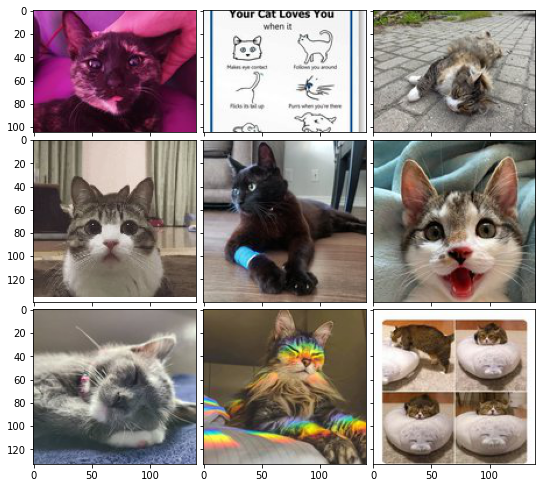

In [ ]:
# Images of top cats
plot_top9(cat_fltr)

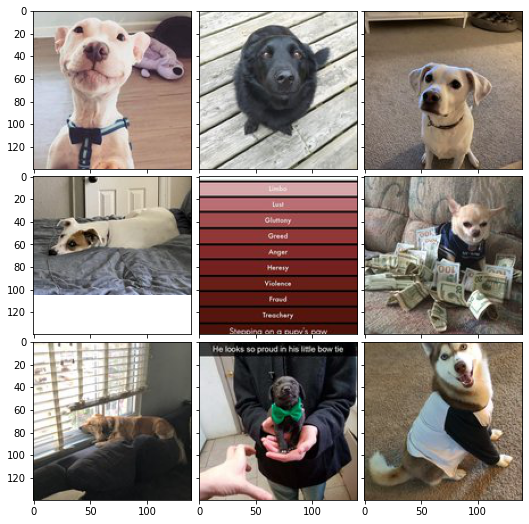

In [ ]:
# Images of top dogs
plot_top9(dog_fltr)

Notice that some posts do not contain animals at all. This suggests that a filtering step requiring the use of YOLO object (animal) recognition model will need to be applied in hopes of retaining images that certainly (above a reasonable threshold) contain the target animal.

### Continue filtering the data according to the below:


1.   Delete images that have a score of `1`. This is because Reddit automatically upvotes initial posts. Given only the `score` it's impossible to know if any users have evaluated an image with a `score` of 1 at all (e.g., 12 upvoting and 11 downvoting resulting in a `score` of 1) or if it simply has a score of `1` since it was posted.
2.   Then sample uniformly from quantiles of `score` to give the model ample variability from which to learn (without `1`-inflation)



In [ ]:
cat_fltr = cat_fltr[cat_fltr.score != 1]
dog_fltr = dog_fltr[dog_fltr.score != 1]

In [ ]:
print(cat_fltr.shape)
dog_fltr.shape

(5176, 16)


(3442, 16)

Note that dropping images with a score of 1 removes a lot of data, so this step may be foregone in the future if it is not necessary

In [ ]:
# Create new columns with the quantile label/factor
labels = ['q1', 'q2', 'q3', 'q4']
cat_fltr['quantile'] = pd.qcut(cat_fltr.score, q = 4, labels = labels)
cat_q_min = cat_fltr.value_counts('quantile').min()
dog_fltr['quantile'] = pd.qcut(dog_fltr.score, q = 4,labels = labels)
dog_q_min = dog_fltr.value_counts('quantile').min()
# downsample to the minimum quantile for each
cat_df = pd.concat([cat_fltr[cat_fltr['quantile'].eq(label)].sample(cat_q_min) for label in labels])
dog_df = pd.concat([dog_fltr[dog_fltr['quantile'].eq(label)].sample(dog_q_min) for label in labels])
# Sanity checks
print('Min cat quantile size:', cat_q_min, '\nValue counts: ', cat_df.value_counts('quantile').values) 
print('Min dog quantile size:', dog_q_min, '\nValue counts: ', dog_df.value_counts('quantile').values)

Min cat quantile size: 1204 
Value counts:  [1204 1204 1204 1204]
Min dog quantile size: 781 
Value counts:  [781 781 781 781]


In [ ]:
# Does this leave us with enough data?
print(cat_df.shape)
dog_df.shape

(4816, 17)


(3124, 17)

### some conclusions at this stage
One year of cat data, filtered, provided us with 1152 images, and for dogs 740 images. Let's instead pull data from more years to build a bigger final dataset

To do so, make edits to scraping script and re-run the above steps.

# Analyzing the `score` variable

### Let's view the raw `score` variable

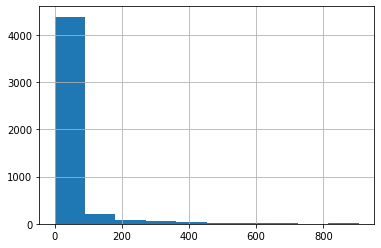

In [ ]:
cat_df.score.hist()

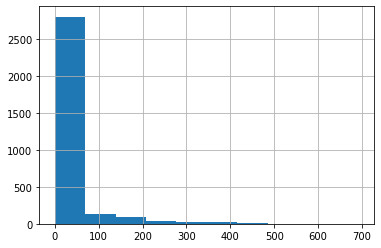

In [ ]:
dog_df.score.hist()

The histograms are skewed but not as severely as the original data that contained all of the data where `score == 1`

#### Adjust the score by time since `creation_date`
Simply divide by the time elapsed since the post was created to control for the possible effect that the post might have gained more votes over time as it was left up on Reddit

In [ ]:
cat_df['score_per_day'] = cat_df.score / [x.days for x in dt.datetime.today() - cat_df.created_date]
dog_df['score_per_day'] = dog_df.score / [x.days for x in dt.datetime.today() - dog_df.created_date]

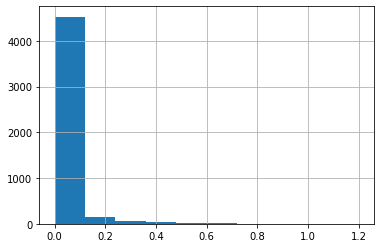

In [ ]:
cat_df.score_per_day.hist()

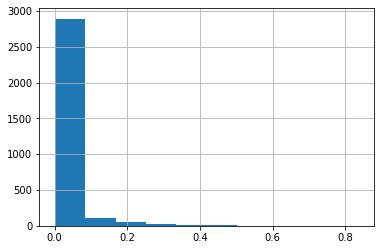

In [ ]:
dog_df.score_per_day.hist()

Another approach is to divide by the number of subreddit subscribers, as a way to estimate how many people may have reasonably viewed the post and contributed to voting, since posts are presented on Reddit in chronological order and time left up on Reddit might not have that much impact on the score, as much as the initial exposure the post gets due to traffic at the time of creation.

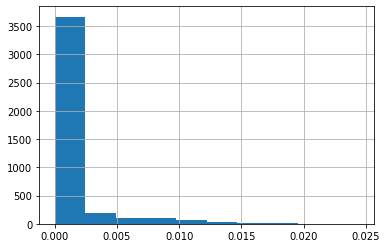

In [ ]:
pd.Series(cat_df.score / cat_df.subreddit_subscribers).hist()

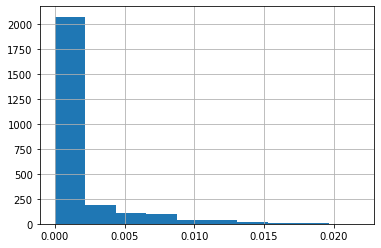

In [ ]:
pd.Series(dog_df.score / dog_df.subreddit_subscribers).hist()

This approach seems to mitigate skew much better.

In [ ]:
cat_df['score_per_sub'] = cat_df.score / cat_df.subreddit_subscribers
dog_df['score_per_sub'] = dog_df.score / dog_df.subreddit_subscribers

In [ ]:
# Write out the datasets
cat_df.to_csv('data/cat_model_data.csv', index=False)
dog_df.to_csv('data/dog_model_data.csv', index=False)